# This Notebook tries to Predict number of Stickers Sold.

### Loading Dataset.

Let's start by loading the data for exploration.

In [4]:
# Necessary libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
path = "../../../Data/playground-series-s5e1/"
train = pd.read_csv(path+"train.csv")
test = pd.read_csv(path+"test.csv")

A quick peek at the data.

In [7]:
train.head()

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [8]:
train.tail()

,id,date,country,store,product,num_sold
230125,230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0
230126,230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0
230127,230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0
230128,230128,2016-12-31,Singapore,Premium Sticker Mart,Kerneler,1242.0
230129,230129,2016-12-31,Singapore,Premium Sticker Mart,Kerneler Dark Mode,1622.0


In [9]:
test.head()

,id,date,country,store,product
0,230130,2017-01-01,Canada,Discount Stickers,Holographic Goose
1,230131,2017-01-01,Canada,Discount Stickers,Kaggle
2,230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers
3,230133,2017-01-01,Canada,Discount Stickers,Kerneler
4,230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode


In [10]:
test.tail()

,id,date,country,store,product
98545,328675,2019-12-31,Singapore,Premium Sticker Mart,Holographic Goose
98546,328676,2019-12-31,Singapore,Premium Sticker Mart,Kaggle
98547,328677,2019-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers
98548,328678,2019-12-31,Singapore,Premium Sticker Mart,Kerneler
98549,328679,2019-12-31,Singapore,Premium Sticker Mart,Kerneler Dark Mode


In [11]:
# Let's make the id column the index of the dataframes. 
train = train.set_index("id")
test = test.set_index("id")

### Exploratory Data Analysis.

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230130 entries, 0 to 230129
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   date      230130 non-null  object 
 1   country   230130 non-null  object 
 2   store     230130 non-null  object 
 3   product   230130 non-null  object 
 4   num_sold  221259 non-null  float64
dtypes: float64(1), object(4)
memory usage: 10.5+ MB


In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98550 entries, 230130 to 328679
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     98550 non-null  object
 1   country  98550 non-null  object
 2   store    98550 non-null  object
 3   product  98550 non-null  object
dtypes: object(4)
memory usage: 3.8+ MB


In [22]:
# Number of stickers sale missing.
null_num_sold = train.loc[train["num_sold"].isnull() == True, ["num_sold"]]
null_num_sold_count = len(null_num_sold)
percent_missing = np.round((null_num_sold_count/len(train))*100, 2)
print(f"{null_num_sold_count} stickers have missing values out of {len(train)} total sticketrs representing {percent_missing}%")

8871 stickers have missing values out of 230130 total sticketrs representing 3.85%


In [26]:
# Countries in train.
train["country"].value_counts()

country
Canada       38355
Finland      38355
Italy        38355
Kenya        38355
Norway       38355
Singapore    38355
Name: count, dtype: int64

In [28]:
# Stores selling stickers.
train["store"].value_counts()

store
Discount Stickers       76710
Stickers for Less       76710
Premium Sticker Mart    76710
Name: count, dtype: int64

In [30]:
 # Products sold.
train["product"].value_counts()

product
Holographic Goose     46026
Kaggle                46026
Kaggle Tiers          46026
Kerneler              46026
Kerneler Dark Mode    46026
Name: count, dtype: int64

### Visualization.

We will make a barplot, histogram and line for various aspects of the dataset.

In [34]:
# Barplot for the different stores in each country.
stores_country = train.groupby(["country", "store"])[["store"]].count()
stores_country = stores_country.rename(columns = {"store": "store_count"})
stores_country = stores_country.reset_index()
wide_stores_country = stores_country.pivot(index= "country", columns="store", values="store_count")

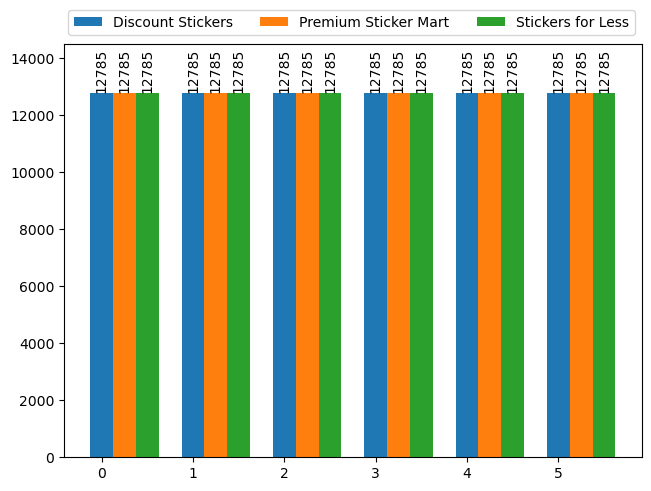

In [113]:
fig, ax = plt.subplots(layout='constrained')

x = np.arange(len(wide_stores_country))
width = 0.25
multiplier = 0

for attribute in wide_stores_country.columns:
    offset = multiplier * width
    rects = ax.bar(x+offset, wide_stores_country[attribute], width=width, label=attribute)
    ax.bar_label(rects, rotation=90)
    multiplier += 1

#ax.set_xticks(x + width, wide_stores_country.index)
ax.legend(loc="upper right", bbox_to_anchor=(1,1.1), ncols=3)
ax.set_ylim(0, 14500) 
plt.show()